In [53]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.special import sici

In [9]:
# Silica properties

# These numbers roughly reproduce the results in
# https://opg.optica.org/ol/abstract.cfm?uri=ol-32-15-2200
E     = 300 * 1e9  # Young's modulus; Pa; usually silica has ~73 GPa
sigma = 0.17       # Poisson's ratio
rho   = 2200       # kg / m^3

cl = np.sqrt(E * (1 - sigma) / (rho * (1 + sigma) * (1 - 2 * sigma)))
ct = np.sqrt(E / (2 * rho * (1 + sigma)))

In [10]:
lam = E * sigma / ( (1 + sigma) * (1 - 2 * sigma) )
mu  = E / (2 * (1 + sigma))

v0 = np.sqrt((lam + 2 * mu) / rho)
v1 = np.sqrt(mu / rho)

In [15]:
# These two functions give the same result
def func_landau(ff, R, cl, ct):
    omega = 2 * np.pi * ff * 1e6

    kk = omega / cl
    
    return np.tan(kk * R) / (kk * R) - 1 / (1 - (kk* R * cl / 2 / ct)**2)

def func(ff, R, v0, v1):
    omega = 2 * np.pi * ff * 1e6

    kk = omega / v1
    hh = omega / v0
    
    return np.tan(hh * R) / (hh * R) - 1 / (1 - 0.25 * (kk**2 * R**2))

Solve for resonant freuqency of the breathing mode (n, l) = (1, 0) of a 30 um sphere

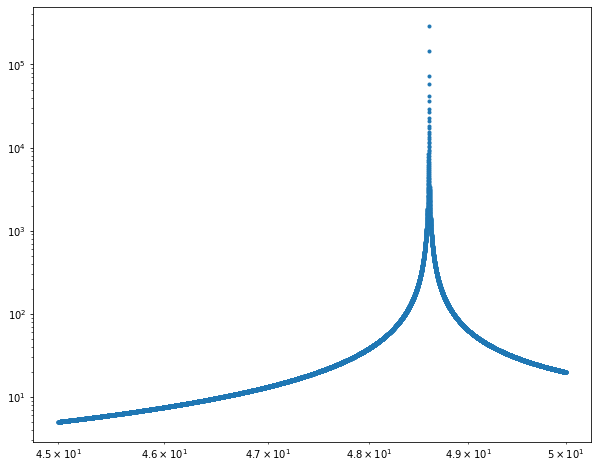

In [111]:
R = 50e-6 # 30 um sphere

ff = np.linspace(45, 50, 20000)

# The function oscillate very quickly around zero
# so need a better way to solve for roots
fig, ax = plt.subplots(figsize=(10, 8))
plt.loglog(ff, np.abs(func(ff, R, v0, v1)), '.')
# plt.plot(ff, func_landau(ff, R, cl, ct))

In [17]:
fsolve(func_landau, x0=150, args=(R, cl, ct))

array([-3.62711308e-07])

In [112]:
# f_10 = 161.9945 * 1e6  # Take 161.9945 MHz for now
f_10 = 48.6 * 1e6
omega_10 = 2 * np.pi * f_10
k_10 = omega_10 / cl

Calculate the mode function and effective mass

In [114]:
def un(kn, rr, R):
    # Normalize such that un(R) = 1
    N = (-1 / R) * np.sin(kn * R) + (kn / R) * np.cos(kn * R)
    
    _un = (-1 / rr) * np.sin(kn * rr) + (kn / rr) * np.cos(kn * rr)
    return _un / N

def An(kn, R):
    N = (-1 / R) * np.sin(kn * R) + (kn / R) * np.cos(kn * R)
    return 1 / N

C:\Users\yuhan\AppData\Local\Temp\ipykernel_12860\4052146212.py:5: RuntimeWarning: divide by zero encountered in true_divide
  _un = (-1 / rr) * np.sin(kn * rr) + (kn / rr) * np.cos(kn * rr)
C:\Users\yuhan\AppData\Local\Temp\ipykernel_12860\4052146212.py:5: RuntimeWarning: invalid value encountered in multiply
  _un = (-1 / rr) * np.sin(kn * rr) + (kn / rr) * np.cos(kn * rr)


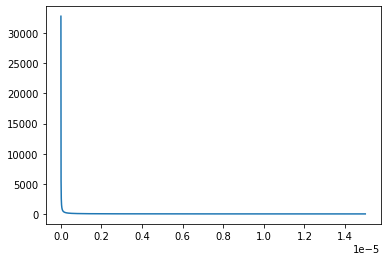

In [43]:
rr = np.linspace(0, R, 10000)
plt.plot(rr, un(k_10, rr, R))

In [115]:
def _func_qn(kn, r):
    ret = -1 * np.sin(kn * r) / (kn**2) + r * np.cos(kn * r) / kn + 2 * r * np.cos(kn * r) / kn + r**2 - 2 / (kn**2)
    return ret
    
def qn(kn, R):
    m = (4 * np.pi / 3) * R**3 * rho
    integral = An(kn, R) * (_func_qn(kn, R) - _func_qn(kn, 0))
    # print(m, integral)
    
    Jn = (3 / (R**4)) * integral
    
    # Output is in SI units
    return m * R * Jn

In [116]:
def _func_Mn(kn, r):
    second = (kn / 4) * (2 * kn * r + np.sin(2 * kn * r))
    third = kn * sici(2 * kn * r)[0]
    
    return (second + third)
    
def Mn(kn, R):
    first = kn * sici(2 * kn * R)[0] - (np.sin(kn * R))**2 / R
    integral = (An(kn, R)**2) * (first + _func_Mn(kn, R) - _func_Mn(kn, 0))
    
    return 4 * np.pi * rho * integral

In [123]:
kb = 1.38e-23
T  = 10   # K
v_dm = 230 * 1e3  # m/s
Qn = 1e9
tau_int = 1e8     # s
N_sphere = 1e9

In [124]:
hmin = np.sqrt(1/ N_sphere) * np.sqrt(4 * kb * T * Mn(k_10, R) * v_dm / (Qn * qn(k_10, R)**2 * np.power(omega_10, 5/2) )) * np.power(tau_int, -1/4)

In [125]:
c = 299792458
Gn = 6.474e-11 # SI
rho_dm = 300 * 1.6e-19

d_min = np.sqrt(c**2 / (8 * np.pi * Gn * rho_dm)) * omega_10 * hmin

In [126]:
print(f'{d_min:.2e}')

5.91e+08
